In [158]:
import pandas as pd

In [159]:

import pandas as pd
from functionwords import FunctionWords
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import random 
from tqdm import tqdm
import statsmodels.api as sm
import functionwords

In [160]:
root = "/shared/3/projects/benlitterer/podcastData/diarizationMerged/"
pathList = []
for path, subdirs, files in os.walk(root):
    for name in files:
        pathList.append(os.path.join(path, name))

random.seed(85)
paths = random.sample(pathList, 500)


In [168]:

def getTurnDf(inDf):

    prevSpeakList = []
    
    featureNames = ["content", "mfcc1_sma3", "mfcc2_sma3", "mfcc3_sma3", "mfcc4_sma3", "F0semitoneFrom27.5Hz_sma3nz", "F1frequency_sma3nz"]

    #the beginning is for content the end is for 
    emptyRow = [""] + [0 for i in range(1, len(featureNames)+1)] #[None for i in range(1, len(featureNames) +2)]
    prevData = emptyRow 
    currData = emptyRow
    turnCount = 0 

    #drop rows where there is no speaker or content 
    inDf = inDf.dropna(subset=["content", "speakers"])
    inDf = inDf[(inDf["content"].apply(len) != 0) & (inDf["speakers"].apply(len) != 0)]

    #use same algo but keep track of lag. 
    #we want to keep rows where we don't have the lag, just put na in every column? 
    #this is where we store someone's speech for the last time they spoke, i.e. speaker_t-1
    speakers = set([item for row in inDf["speakers"].to_list() for item in row])
    prevDict = {speakName:(None, [""] + [0 for i in range(1, len(featureNames)+1)]) for speakName in speakers}

    #initialize list of who's speaking 
    speakList = []
    prevSpeakList = []

    
    #initialize this as whoever speaks first 
    if len([item for row in inDf["speakers"].to_list() for item in row]) > 0: 
        currSpeaker = [item for row in inDf["speakers"].to_list() for item in row][0]
        prevSpeaker = [item for row in inDf["speakers"].to_list() for item in row][0]

        tupList = []
        for i, row in inDf.iterrows(): 


            
            #if someone is speaking now and someone was speaking before 
            #if len(speakList) > 0 and len(prevSpeakList) > 0: 
            nextSpeaker = ""
            if len(row["speakers"]) > 0: 
                nextSpeaker = row["speakers"][0]
            
            if nextSpeaker != currSpeaker: 
                #remember, we haven't update the current speaker yet. We see that there is a new one, so we want to dump our old data into 
                #the currSpeaker from the last iteration and then update to who is actually speaking on this turn 
                #note here we wait for the person who was speaking to drop out, 
                #which bumps any other people who were speaking forward in the list 
            
                #only if there's something to append 
                #TODO: revisit if this is the preferred way to do this 
                if len(currData[0]) > 0 and currSpeaker != "":  
                    #we want the mean of the prosodic features within speaker turns 
                    currData =  [currData[0]] + [item/currData[-1] for item in currData[1:-1]] + [currData[-1]]

                    #get the data from the last time this speaker spoke 
                    laggedTup = prevDict[currSpeaker]

                    #we will only use the actual data if the lag exists and 
                    #is within a certain proximity to the current chunk of text
                    laggedData = [""] + [0 for i in range(1, len(featureNames)+1)]

                    #this can be used to clear out any rows where we don't have a lagged value 
                    laggedDist = None

                    #how far back was this lag
                    turnCount += 1
                    prevTurnCount = laggedTup[0]
                    if prevTurnCount != None: 
                        laggedDist = turnCount - prevTurnCount 

                        #if there are 3 or less speakers inbetween 
                        #this utterance and the last time they spoke 
                        if laggedDist <= 4:
                            laggedData = laggedTup[1] 

                    tupList.append(prevData + currData + laggedData + [laggedDist, prevSpeaker, currSpeaker, turnCount])

                    #the person who's speech we just wrote as a tuple should get 
                    #tracked so we know the last time they spoke and the associated data 
                    #but only update if there was real speech 
                    prevDict[currSpeaker] = (turnCount, currData)

                    prevData = currData

                    #update so that we have the speaker whose info we just wrote as previous
                    #and the speaker who is actually speaking now as the current speaker (but we didn't write their info yet)
                prevSpeaker = currSpeaker
                currSpeaker = nextSpeaker  
                    
                #if there was nothing to append with the current speaker then we don't update prevData or prevDict
                #that way we have a chance to consider a turn with blank text inbetween 
                #else:
                    #prevDict[currSpeaker] = currData
                    #prevData = [""] + [0 for i in range(1, len(featureNames)+1)]
                currData =  [""] + [0 for i in range(1, len(featureNames)+1)]


            #before updating currSpeaker, assign previous to the currSpeaker from the last iteration
            #prevSpeaker = currSpeaker 
            #currSpeaker = nextSpeaker 
            
            #who is speaking rn, after updating using old information 
            speakList = row["speakers"]

            #get the current content 
            content = row["content"]
            
            #we only consider when we have speakers associated with text 
            #just skip if we don't 
            if len(speakList) > 0: 
                """
                prevSpeakList = speakList

                if len(prevSpeakList) > 0: 
                    prevSpeaker = prevSpeakList[0]
                else: 
                    prevSpeaker = []
                """
                #if the content is legit, add it as well as the prosodic features to the running
                #data we have for this speaker 
                if content == content and content != None: 
                    currData[0] += row["content"] 
                
                for i in range(1, len(featureNames)): 
                    currFeature = row[featureNames[i]]
                    currData[i] += currFeature
                
                #this tracks how many times we've added to the feature vector
                currData[-1] += 1
            


        return tupList 

In [170]:
allTups = []

for path in tqdm(paths): 

    #just want to load in an example file here 
    currDf = pd.read_json(path, orient="records", lines=True)

    #get the first speaker
    fSpeaker = ""
    for cSpeaker in currDf["speakers"]: 
        if len(cSpeaker) > 0: 
            fSpeaker = cSpeaker[0]
            break

    currTups = getTurnDf(currDf)

    #add speaker and path to currTups
    temp = currTups
    if temp != None and temp == temp: 
        currTups = [item + [fSpeaker, path] for item in temp]
        
        allTups = allTups + currTups

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [08:26<00:00,  1.01s/it]


In [171]:
#get speakers to consider 

featureNames = ["content", "mfcc1_sma3", "mfcc2_sma3", "mfcc3_sma3", "mfcc4_sma3", "F0semitoneFrom27.5Hz_sma3nz", "F1frequency_sma3nz"]
colNames = ["a_" + featureName for featureName in featureNames] + ["a_tokenCount"] + ["b_" + featureName for featureName in featureNames] + ["b_tokenCount"] + ["lag_" + featureName for featureName in featureNames] + ["lag_tokenCount", "laggedDistance", "speakerA",  "speakerB", "turnCount", "fSpeaker", "fPath"]
currDf = pd.DataFrame(allTups, columns=colNames)

In [172]:
currDf.shape

(50211, 30)

In [173]:
fw = FunctionWords(function_words_list="english")

currDf["a_fwCount"] = currDf["a_content"].apply(lambda x: sum(fw.transform(x)))
currDf["b_fwCount"] = currDf["b_content"].apply(lambda x: sum(fw.transform(x)))
currDf["lag_fwCount"] = currDf["lag_content"].apply(lambda x: sum(fw.transform(x)))

In [174]:
import numpy as np

In [175]:
#get a unique tag for each podcast speaker combo 
currDf["speakerTag"] = currDf["fPath"] + currDf["speakerB"].apply(lambda x: x.split("_")[1])

In [249]:
currDf.columns

Index(['a_content', 'a_mfcc1_sma3', 'a_mfcc2_sma3', 'a_mfcc3_sma3',
       'a_mfcc4_sma3', 'a_F0semitoneFrom27.5Hz_sma3nz', 'a_F1frequency_sma3nz',
       'a_tokenCount', 'b_content', 'b_mfcc1_sma3', 'b_mfcc2_sma3',
       'b_mfcc3_sma3', 'b_mfcc4_sma3', 'b_F0semitoneFrom27.5Hz_sma3nz',
       'b_F1frequency_sma3nz', 'b_tokenCount', 'lag_content', 'lag_mfcc1_sma3',
       'lag_mfcc2_sma3', 'lag_mfcc3_sma3', 'lag_mfcc4_sma3',
       'lag_F0semitoneFrom27.5Hz_sma3nz', 'lag_F1frequency_sma3nz',
       'lag_tokenCount', 'laggedDistance', 'speakerA', 'speakerB', 'turnCount',
       'fSpeaker', 'fPath', 'a_fwCount', 'b_fwCount', 'lag_fwCount',
       'speakerTag', 'a_fwNormed', 'b_fwNormed', 'lag_fwNormed',
       'a_tokCountNormed', 'b_tokCountNormed', 'lag_tokenCountNormed',
       'lag_tokCountNormed'],
      dtype='object')

In [248]:
#we really only want to consider speakers with lots of text 
#speakerCounts = pd.DataFrame(currDf["speakerTag"].value_counts())
#speakerCounts = speakerCounts[speakerCounts["count"] >= 15]

#find rows corresponding to speakers who don't speak much 
currDf.head() 


,a_content,a_mfcc1_sma3,a_mfcc2_sma3,a_mfcc3_sma3,a_mfcc4_sma3,a_F0semitoneFrom27.5Hz_sma3nz,a_F1frequency_sma3nz,a_tokenCount,b_content,b_mfcc1_sma3,...,b_fwCount,lag_fwCount,speakerTag,a_fwNormed,b_fwNormed,lag_fwNormed,a_tokCountNormed,b_tokCountNormed,lag_tokenCountNormed,lag_tokCountNormed
1,"Hey guys, welcome to our podcast. You're here...",31.331896,7.382284,10.355899,-4.629202,17.716232,656.811736,39,"of our listeners know, the world is going thr...",35.202164,...,10,0,/shared/3/projects/benlitterer/podcastData/dia...,-1.197598,-1.189710,-1.850659,-0.916520,-1.242269,-1.848253,-1.848253
2,"of our listeners know, the world is going thr...",35.202164,1.521370,1.497069,-14.283562,24.485687,674.980729,20,"music majors, we felt the need to shed some l...",34.599405,...,10,0,/shared/3/projects/benlitterer/podcastData/dia...,-1.189710,-1.177299,-1.909298,-1.242269,-1.104692,-1.851984,-1.851984
3,"music majors, we felt the need to shed some l...",34.599405,11.247689,14.058461,-5.736766,21.195098,662.556381,23,"With everything going on with COVID-19, all c...",30.911088,...,8,16,/shared/3/projects/benlitterer/podcastData/dia...,-1.177299,-1.757878,-1.197598,-1.104692,-1.715147,-0.916520,-0.916520
4,"With everything going on with COVID-19, all c...",30.911088,-1.476266,11.074151,-0.341126,20.064262,705.315823,18,People have been forced to find new and creat...,33.931160,...,35,10,/shared/3/projects/benlitterer/podcastData/dia...,-1.757878,0.462665,-1.189710,-1.715147,0.908977,-1.242269,-1.242269
5,People have been forced to find new and creat...,33.931160,7.638161,11.761609,-7.699453,24.063536,718.494343,91,"Another example on March 20, 2020, the Rotter...",30.050658,...,33,10,/shared/3/projects/benlitterer/podcastData/dia...,0.462665,0.506300,-1.177299,0.908977,1.202165,-1.104692,-1.104692


In [190]:
currDf = currDf[currDf["speakerA"] != currDf["speakerB"]]

In [235]:
speakerStats = currDf[["b_fwCount", "speakerTag"]].groupby(["speakerTag"]).agg([np.mean, np.std, len]).droplevel(level=0, axis=1)
speakerStats.columns = ["fwMean", "fwStd", "fwLen"]

/tmp/ipykernel_597352/4287267026.py:1: FutureWarning: The provided callable <function mean at 0x7f06dc41f060> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  speakerStats = currDf[["b_fwCount", "speakerTag"]].groupby(["speakerTag"]).agg([np.mean, np.std, len]).droplevel(level=0, axis=1)
/tmp/ipykernel_597352/4287267026.py:1: FutureWarning: The provided callable <function std at 0x7f06dc41f1a0> is currently using SeriesGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
  speakerStats = currDf[["b_fwCount", "speakerTag"]].groupby(["speakerTag"]).agg([np.mean, np.std, len]).droplevel(level=0, axis=1)


In [194]:

speakerStats = currDf[["b_fwCount", "speakerTag"]].groupby(["speakerTag"]).agg([np.mean, np.std, len]).droplevel(level=0, axis=1)
speakerStats.columns = ["fwMean", "fwStd", "fwLen"]

def normalizeFwUsage(inRow, speakerCol, fwCol): 
    #within each speaker 
    #normalize the function word usage for each speaker within each conversation 

    #get stats for the speaker we're interested in 
    speakerTag = inRow["fPath"] + inRow[speakerCol].split("_")[1]

    try: 
        mean, std, length = currStats = speakerStats.loc[speakerTag]
    except: 
        return np.nan

    if std != 0: 
        return (inRow[fwCol] - mean) / std
    else: 
        return np.nan

currDf["a_fwNormed"] = currDf.apply(normalizeFwUsage, args=["speakerA", "a_fwCount"], axis=1)
currDf["b_fwNormed"] = currDf.apply(normalizeFwUsage, args=["speakerB", "b_fwCount"], axis=1)

#note here we use B's statistics but we normalize B's lagged value 
currDf["lag_fwNormed"] = currDf.apply(normalizeFwUsage, args=["speakerB", "lag_fwCount"], axis=1)

#currDf.head(5000).apply(normalizeFwUsage, args=["speakerA", "a_fwCount"], axis=1)

/tmp/ipykernel_597352/3423379766.py:1: FutureWarning: The provided callable <function mean at 0x7f06dc41f060> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  speakerStats = currDf[["b_fwCount", "speakerTag"]].groupby(["speakerTag"]).agg([np.mean, np.std, len]).droplevel(level=0, axis=1)
/tmp/ipykernel_597352/3423379766.py:1: FutureWarning: The provided callable <function std at 0x7f06dc41f1a0> is currently using SeriesGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
  speakerStats = currDf[["b_fwCount", "speakerTag"]].groupby(["speakerTag"]).agg([np.mean, np.std, len]).droplevel(level=0, axis=1)
/tmp/ipykernel_597352/3423379766.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = v

In [218]:
currDf.columns

Index(['a_content', 'a_mfcc1_sma3', 'a_mfcc2_sma3', 'a_mfcc3_sma3',
       'a_mfcc4_sma3', 'a_F0semitoneFrom27.5Hz_sma3nz', 'a_F1frequency_sma3nz',
       'a_tokenCount', 'b_content', 'b_mfcc1_sma3', 'b_mfcc2_sma3',
       'b_mfcc3_sma3', 'b_mfcc4_sma3', 'b_F0semitoneFrom27.5Hz_sma3nz',
       'b_F1frequency_sma3nz', 'b_tokenCount', 'lag_content', 'lag_mfcc1_sma3',
       'lag_mfcc2_sma3', 'lag_mfcc3_sma3', 'lag_mfcc4_sma3',
       'lag_F0semitoneFrom27.5Hz_sma3nz', 'lag_F1frequency_sma3nz',
       'lag_tokenCount', 'laggedDistance', 'speakerA', 'speakerB', 'turnCount',
       'fSpeaker', 'fPath', 'a_fwCount', 'b_fwCount', 'lag_fwCount',
       'speakerTag', 'a_fwNormed', 'b_fwNormed', 'lag_fwNormed'],
      dtype='object')

In [221]:
#to make this more broadly applicable, we can just make these first two lines take an argument
#for the feature of interest, then wrap this all in a function 
speakerStats = currDf[["b_tokenCount", "speakerTag"]].groupby(["speakerTag"]).agg([np.mean, np.std, len]).droplevel(level=0, axis=1)
speakerStats.columns = ["tokCountMean", "tokCountStd", "tokCountLen"]

def normalizeFwUsage(inRow, speakerCol, fwCol): 
    #within each speaker 
    #normalize the function word usage for each speaker within each conversation 

    #get stats for the speaker we're interested in 
    speakerTag = inRow["fPath"] + inRow[speakerCol].split("_")[1]

    try: 
        mean, std, length = currStats = speakerStats.loc[speakerTag]
    except: 
        return np.nan

    if std != 0: 
        return (inRow[fwCol] - mean) / std
    else: 
        return np.nan

currDf["a_tokCountNormed"] = currDf.apply(normalizeFwUsage, args=["speakerA", "a_tokenCount"], axis=1)
currDf["b_tokCountNormed"] = currDf.apply(normalizeFwUsage, args=["speakerB", "b_tokenCount"], axis=1)

#note here we use B's statistics but we normalize B's lagged value 
currDf["lag_tokCountNormed"] = currDf.apply(normalizeFwUsage, args=["speakerB", "lag_tokenCount"], axis=1)


/tmp/ipykernel_597352/2315527912.py:3: FutureWarning: The provided callable <function mean at 0x7f06dc41f060> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  speakerStats = currDf[["b_tokenCount", "speakerTag"]].groupby(["speakerTag"]).agg([np.mean, np.std, len]).droplevel(level=0, axis=1)
/tmp/ipykernel_597352/2315527912.py:3: FutureWarning: The provided callable <function std at 0x7f06dc41f1a0> is currently using SeriesGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
  speakerStats = currDf[["b_tokenCount", "speakerTag"]].groupby(["speakerTag"]).agg([np.mean, np.std, len]).droplevel(level=0, axis=1)
/tmp/ipykernel_597352/2315527912.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexe

In [222]:
print(currDf.shape[0])
print(currDf.dropna(subset=["a_fwNormed", "b_fwNormed", "lag_fwNormed", "a_tokCountNormed", "b_tokCountNormed","lag_tokCountNormed" ]).shape[0])
currDf = currDf.dropna(subset=["a_fwNormed", "b_fwNormed", "lag_fwNormed", "a_tokCountNormed", "b_tokCountNormed","lag_tokCountNormed"])

48315
48219


/opt/anaconda/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


(0.0, 200.0)

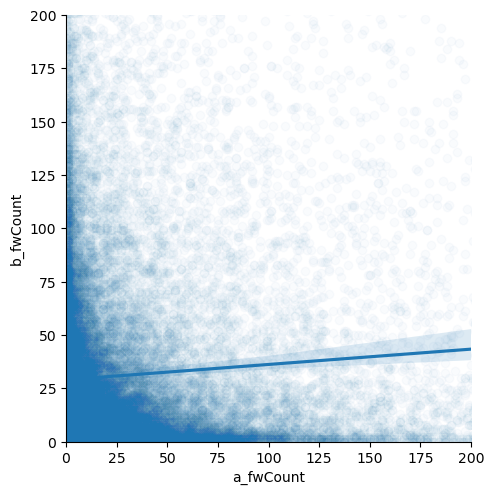

In [200]:
#sns.scatterplot(data=currDf, x="b_fwNormed", y="a_fwNormed", alpha=.05)
sns.lmplot(data=currDf, x="a_fwCount", y="b_fwCount", scatter_kws={"alpha":.025})
plt.xlim(0, 200)
plt.ylim(0, 200)

In [223]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [224]:
ols = smf.ols("b_fwNormed ~ a_fwNormed + b_tokCountNormed + a_tokCountNormed", currDf)
fwReg_noLag = ols.fit()

In [215]:
currDf.columns

Index(['a_content', 'a_mfcc1_sma3', 'a_mfcc2_sma3', 'a_mfcc3_sma3',
       'a_mfcc4_sma3', 'a_F0semitoneFrom27.5Hz_sma3nz', 'a_F1frequency_sma3nz',
       'a_tokenCount', 'b_content', 'b_mfcc1_sma3', 'b_mfcc2_sma3',
       'b_mfcc3_sma3', 'b_mfcc4_sma3', 'b_F0semitoneFrom27.5Hz_sma3nz',
       'b_F1frequency_sma3nz', 'b_tokenCount', 'lag_content', 'lag_mfcc1_sma3',
       'lag_mfcc2_sma3', 'lag_mfcc3_sma3', 'lag_mfcc4_sma3',
       'lag_F0semitoneFrom27.5Hz_sma3nz', 'lag_F1frequency_sma3nz',
       'lag_tokenCount', 'laggedDistance', 'speakerA', 'speakerB', 'turnCount',
       'fSpeaker', 'fPath', 'a_fwCount', 'b_fwCount', 'lag_fwCount',
       'speakerTag', 'a_fwNormed', 'b_fwNormed', 'lag_fwNormed'],
      dtype='object')

In [ ]:
#get the normalized tokenCounts, this is looking more explicitly at synchrony 

In [225]:
fwReg_noLag.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             b_fwNormed   R-squared:                       0.919
Model:                            OLS   Adj. R-squared:                  0.919
Method:                 Least Squares   F-statistic:                 1.822e+05
Date:                Tue, 07 May 2024   Prob (F-statistic):               0.00
Time:                        13:01:59   Log-Likelihood:                -7153.4
No. Observations:               48219   AIC:                         1.431e+04
Df Residuals:                   48215   BIC:                         1.435e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -0.0009      0.001     -0.704      0.481      -0.003       0.002
a_fwNormed           0.0411      0.004     11.381      0.000       0.034       0.048
b_tokCountNormed     0.9564      0.001    737.124      0.000       0.954       0.959
a_tokCountNormed    -0.0347      0.004     -9.886      0.000      -0.042      -0.028
==============================================================================
Omnibus:                    18585.133   Durbin-Watson:                   1.966
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         14322853.113
Skew:                           0.241   Prob(JB):                         0.00
Kurtosis:                      87.431   Cond. No.                         5.94
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [233]:
ols = smf.ols("b_fwNormed ~ a_fwNormed + lag_fwNormed + b_tokCountNormed + a_tokCountNormed", currDf)
fwReg_lag = ols.fit()

In [234]:
fwReg_lag.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             b_fwNormed   R-squared:                       0.919
Model:                            OLS   Adj. R-squared:                  0.919
Method:                 Least Squares   F-statistic:                 1.367e+05
Date:                Tue, 07 May 2024   Prob (F-statistic):               0.00
Time:                        13:06:40   Log-Likelihood:                -7148.0
No. Observations:               48219   AIC:                         1.431e+04
Df Residuals:                   48214   BIC:                         1.435e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -0.0005      0.001     -0.373      0.709      -0.003       0.002
a_fwNormed           0.0408      0.004     11.302      0.000       0.034       0.048
lag_fwNormed         0.0028      0.001      3.289      0.001       0.001       0.004
b_tokCountNormed     0.9563      0.001    736.773      0.000       0.954       0.959
a_tokCountNormed    -0.0344      0.004     -9.812      0.000      -0.041      -0.028
==============================================================================
Omnibus:                    18620.121   Durbin-Watson:                   1.966
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         14325936.567
Skew:                           0.250   Prob(JB):                         0.00
Kurtosis:                      87.440   Cond. No.                         5.95
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [259]:
currDf.columns

Index(['a_content', 'a_mfcc1_sma3', 'a_mfcc2_sma3', 'a_mfcc3_sma3',
       'a_mfcc4_sma3', 'a_F0semitoneFrom27.5Hz_sma3nz', 'a_F1frequency_sma3nz',
       'a_tokenCount', 'b_content', 'b_mfcc1_sma3', 'b_mfcc2_sma3',
       'b_mfcc3_sma3', 'b_mfcc4_sma3', 'b_F0semitoneFrom27.5Hz_sma3nz',
       'b_F1frequency_sma3nz', 'b_tokenCount', 'lag_content', 'lag_mfcc1_sma3',
       'lag_mfcc2_sma3', 'lag_mfcc3_sma3', 'lag_mfcc4_sma3',
       'lag_F0semitoneFrom27.5Hz_sma3nz', 'lag_F1frequency_sma3nz',
       'lag_tokenCount', 'laggedDistance', 'speakerA', 'speakerB', 'turnCount',
       'fSpeaker', 'fPath', 'a_fwCount', 'b_fwCount', 'lag_fwCount',
       'speakerTag', 'a_fwNormed', 'b_fwNormed', 'lag_fwNormed',
       'a_tokCountNormed', 'b_tokCountNormed', 'lag_tokenCountNormed',
       'lag_tokCountNormed', 'aIsFSpeaker', 'bIsFSpeaker'],
      dtype='object')

In [260]:
#conversation duration 
ols = smf.ols("b_fwNormed ~ a_fwNormed + lag_fwNormed + b_tokCountNormed + a_tokCountNormed + turnCount", currDf)
fwRegTurnCount= ols.fit()
fwRegTurnCount.summary() 

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             b_fwNormed   R-squared:                       0.919
Model:                            OLS   Adj. R-squared:                  0.919
Method:                 Least Squares   F-statistic:                 1.094e+05
Date:                Tue, 07 May 2024   Prob (F-statistic):               0.00
Time:                        13:30:09   Log-Likelihood:                -7140.5
No. Observations:               48219   AIC:                         1.429e+04
Df Residuals:                   48213   BIC:                         1.435e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -0.0044      0.002     -2.702      0.007      -0.008      -0.001
a_fwNormed           0.0406      0.004     11.229      0.000       0.033       0.048
lag_fwNormed         0.0029      0.001      3.369      0.001       0.001       0.005
b_tokCountNormed     0.9564      0.001    736.747      0.000       0.954       0.959
a_tokCountNormed    -0.0341      0.004     -9.700      0.000      -0.041      -0.027
turnCount         1.447e-05   3.72e-06      3.895      0.000    7.19e-06    2.18e-05
==============================================================================
Omnibus:                    18637.280   Durbin-Watson:                   1.966
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         14336403.684
Skew:                           0.254   Prob(JB):                         0.00
Kurtosis:                      87.471   Cond. No.                     1.71e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.71e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [252]:
currDf["aIsFSpeaker"] = currDf["fSpeaker"] == currDf["speakerA"]
currDf["bIsFSpeaker"] = currDf["fSpeaker"] == currDf["speakerB"]

/tmp/ipykernel_597352/1172982458.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currDf["aIsFSpeaker"] = currDf["fSpeaker"] == currDf["speakerA"]
/tmp/ipykernel_597352/1172982458.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currDf["bIsFSpeaker"] = currDf["fSpeaker"] == currDf["speakerB"]


In [264]:
ols = smf.ols("b_fwNormed ~ a_fwNormed*aIsFSpeaker + lag_fwNormed + b_tokCountNormed + a_tokCountNormed", currDf)
aFSpeakerReg = ols.fit()
aFSpeakerReg.summary() 

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             b_fwNormed   R-squared:                       0.919
Model:                            OLS   Adj. R-squared:                  0.919
Method:                 Least Squares   F-statistic:                 9.116e+04
Date:                Tue, 07 May 2024   Prob (F-statistic):               0.00
Time:                        17:10:19   Log-Likelihood:                -7141.0
No. Observations:               48219   AIC:                         1.430e+04
Df Residuals:                   48212   BIC:                         1.436e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                          0.0005      0.002      0.363      0.717      -0.002       0.004
aIsFSpeaker[T.True]               -0.0036      0.003     -1.251      0.211      -0.009       0.002
a_fwNormed                         0.0442      0.004     11.831      0.000       0.037       0.052
a_fwNormed:aIsFSpeaker[T.True]    -0.0085      0.002     -3.515      0.000      -0.013      -0.004
lag_fwNormed                       0.0028      0.001      3.261      0.001       0.001       0.004
b_tokCountNormed                   0.9562      0.001    736.681      0.000       0.954       0.959
a_tokCountNormed                  -0.0344      0.004     -9.798      0.000      -0.041      -0.028
==============================================================================
Omnibus:                    18625.113   Durbin-Watson:                   1.969
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         14325109.247
Skew:                           0.252   Prob(JB):                         0.00
Kurtosis:                      87.438   Cond. No.                         6.27
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [263]:
ols = smf.ols("b_fwNormed ~ a_fwNormed*bIsFSpeaker + lag_fwNormed + b_tokCountNormed + a_tokCountNormed", currDf)
bFSpeakerReg = ols.fit()
bFSpeakerReg.summary() 

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             b_fwNormed   R-squared:                       0.919
Model:                            OLS   Adj. R-squared:                  0.919
Method:                 Least Squares   F-statistic:                 9.113e+04
Date:                Tue, 07 May 2024   Prob (F-statistic):               0.00
Time:                        17:09:52   Log-Likelihood:                -7147.6
No. Observations:               48219   AIC:                         1.431e+04
Df Residuals:                   48212   BIC:                         1.437e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                         -0.0012      0.002     -0.762      0.446      -0.004       0.002
bIsFSpeaker[T.True]                0.0024      0.003      0.847      0.397      -0.003       0.008
a_fwNormed                         0.0405      0.004     10.989      0.000       0.033       0.048
a_fwNormed:bIsFSpeaker[T.True]     0.0013      0.003      0.458      0.647      -0.004       0.007
lag_fwNormed                       0.0028      0.001      3.244      0.001       0.001       0.004
b_tokCountNormed                   0.9563      0.001    736.766      0.000       0.954       0.959
a_tokCountNormed                  -0.0344      0.004     -9.794      0.000      -0.041      -0.028
==============================================================================
Omnibus:                    18629.635   Durbin-Watson:                   1.966
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         14319599.455
Skew:                           0.253   Prob(JB):                         0.00
Kurtosis:                      87.422   Cond. No.                         6.09
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""